In [2]:
import pandas as pd
import ccxt
import requests
from datetime import datetime, timedelta

In [3]:
# Aqui definire una funcion para hacer la extraccion de los datos y darle un correcto formato:

def symbol_data(symbol = 'SOLUSDT', timeframe = '1d', since = (datetime.today() - timedelta(days=1000)).strftime('%Y-%m-%d')):
    exchange = ccxt.bybit({'timeout': 100000,'rateLimit': 1200,})
    ts = int(datetime.timestamp(datetime.strptime(since, '%Y-%m-%d'))*1000)
    aux1 = exchange.fetch_ohlcv(symbol = symbol, since = ts, timeframe=timeframe, limit=1000)
    aux2 = pd.DataFrame(aux1, columns=['date', 'open', 'high', 'low','close','volume'])
    aux2['date'] = pd.to_datetime(aux2['date'], unit = 'ms')
    return aux2

In [4]:
# Aqui definire una funcion para saber cual es el sentimiento del mercado en ese momento:

url = 'https://api.alternative.me/fng/'
params = {'limit':1000,
          'format':'json',
          'date_format':'kr'}

request = requests.get(url=url, params=params)
aux1 = request.json()
sentiment = pd.DataFrame(aux1['data'])


In [5]:
symbol = 'SOL/USDT'
data = symbol_data(symbol=symbol)
sentiment = sentiment.iloc[::-1].reset_index(drop=True)

df = pd.concat([data, sentiment], axis=1)
df = df[['date','open',	'high',	'low',	'close', 'volume', 'value',	'value_classification']]

In [6]:
# En este bloque de código importamos los indicadores técnicos que estaremos utilizando:
import numpy as np
from ta.momentum import RSIIndicator as RSI
from ta.trend import MACD, ADXIndicator
from ta.others import DailyReturnIndicator, DailyLogReturnIndicator
from ta.volatility import AverageTrueRange, DonchianChannel
from ta.volume import VolumeWeightedAveragePrice

In [7]:
# Aquí simplemente le agregamos los datos de los indicadores técnicos a nuestro conjunto de datos:

df_ind = df.copy()

df_ind['rsi'] = RSI(df_ind['close']).rsi()
df_ind['macd'] = MACD(df_ind['close']).macd()
df_ind['adx'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx()
df_ind['adp'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_pos()
df_ind['adm'] = ADXIndicator(df_ind['high'], df_ind['low'], df_ind['close']).adx_neg()
df_ind['dri'] = DailyReturnIndicator(df_ind['close']).daily_return()
df_ind['dlogri'] = DailyLogReturnIndicator(df_ind['close']).daily_log_return()
df_ind['avgtr'] = AverageTrueRange(df_ind['high'], df_ind['low'], df_ind['close']).average_true_range()
df_ind['donch_hband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_hband()
df_ind['donch_lband'] = DonchianChannel(df_ind['high'],df_ind['low'],df_ind['close']).donchian_channel_lband()
df_ind['vwap'] = VolumeWeightedAveragePrice(df_ind['high'],df_ind['low'],df_ind['close'], df_ind['volume']).volume_weighted_average_price()

### Idea 1: Ahora que tenemos todos los indicadores que obtuvimos de aqui, procederemos a etiquetar los precios para crear un modelo de clasificacion, en donde tendremos tres variables: Buy, Sell, Hold.
### Idea 2: Usar los indicadores para encontrar puntos de compra y venta.

In [8]:
# Procederemos con la idea 2 por ahora:

# Entonces generaremos las señales de entrada y de salida:

# Condiciones de Entrada (Compra)
#df_ind['buy_signal'] = (
#    (df_ind['rsi'] < 40) &  # RSI por debajo de 30 (sobreventa)
#    (df_ind['adp'] < 20)  # RSI por debajo de 30 (sobreventa)
    #(df_ind['macd'] > 9) #&  # MACD positivo (indicando tendencia alcista)
    #(df_ind['adx'] > 10) &  # Tendencia fuerte (ADX > 25)
    #(df_ind['close'] > df_ind['vwap']) #&  # Precio por encima del VWAP (tendencia alcista)
    #(df_ind['close'] > df_ind['donch_lband'])  # Precio por encima de la banda inferior de Donchian
#)

# Condiciones de Salida (Venta)
#df_ind['sell_signal'] = (
#    (df_ind['rsi'] > 75) &  # RSI por encima de 70 (sobrecompra)
    #(df_ind['adm'] < 30)
    #(df_ind['macd'] < np.std(df_ind['macd'])) #&  # MACD negativo (indicando tendencia bajista)
#    (df_ind['adx'] > 25) #&  # Tendencia fuerte (ADX > 25)
    #(df_ind['close'] < df_ind['vwap']) #&  # Precio por debajo del VWAP (tendencia bajista)
    #(df_ind['close'] < df_ind['donch_hband'])  # Precio por debajo de la banda superior de Donchian
#)

# Mostrar señales de compra y venta
#df_ind['buy_signal'] = df_ind['buy_signal'].astype(int)  # Convertir a 1 para señal de compra
#df_ind['sell_signal'] = df_ind['sell_signal'].astype(int)  # Convertir a 1 para señal de venta

In [10]:
#import matplotlib.pyplot as plt

# Crear gráfico de precios
#plt.figure(figsize=(14, 8))
#plt.plot(df_ind['close'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
#plt.scatter(df_ind.index[df_ind['buy_signal'] == 1], df_ind['close'][df_ind['buy_signal'] == 1], 
#            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
#plt.scatter(df_ind.index[df_ind['sell_signal'] == 1], df_ind['close'][df_ind['sell_signal'] == 1], 
#            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
#plt.title('Precio de Cierre con Señales de Compra y Venta', fontsize=16)
#plt.xlabel('Fecha', fontsize=12)
#plt.ylabel(f'Precio de {symbol}', fontsize=12)
#plt.legend(loc='best')
#plt.grid(True)

# Mostrar gráfico
#plt.show()

### Ahora vamos a correr el modelo usando los datos de esta nueva crypto para ver como se desempeña.
### El modelo utilizado fue el que se encuentra en modelos_dummys_ver2.0 y el notebook es modelo_supervisado_wo_bssignals.ipynb


Index(['date', 'open', 'high', 'low', 'close', 'volume', 'value',
       'value_classification', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
       'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap', 'buy_signal',
       'sell_signal', 'signals', 'auxiliar', 'mit_10x'],
      dtype='object')


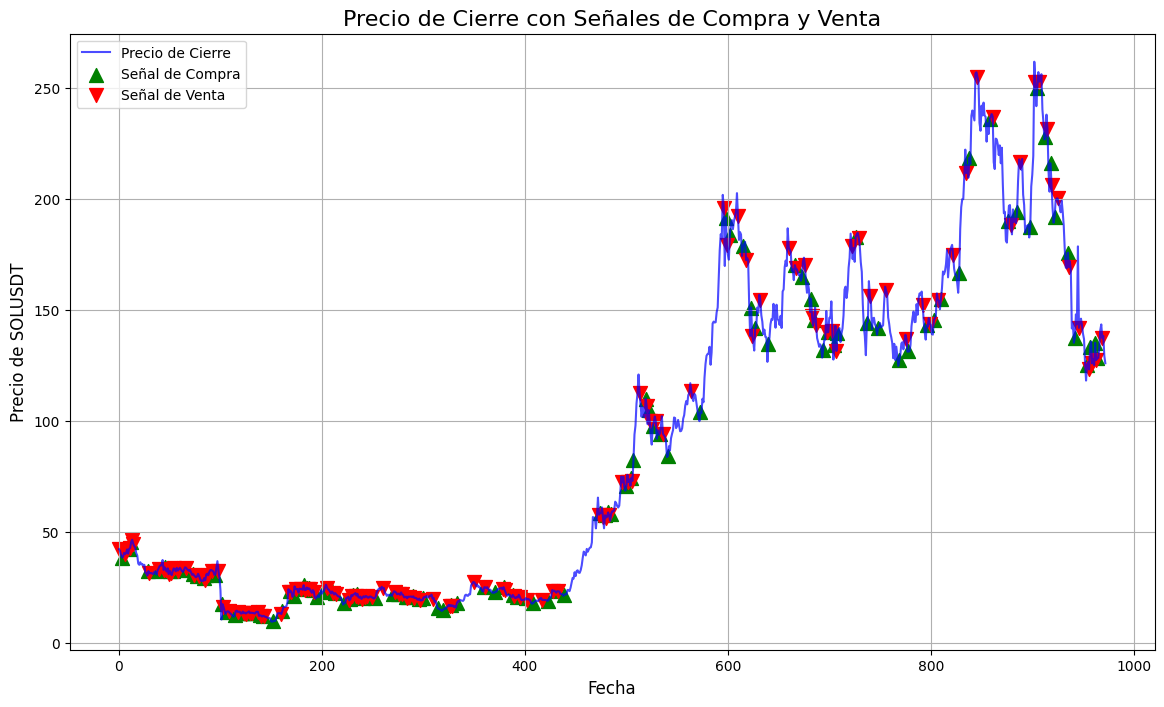

Accuracy: 0.7432
              precision    recall  f1-score   support

         buy       0.25      0.08      0.12        37
        hold       0.76      0.95      0.85       218
        sell       0.75      0.16      0.27        37

    accuracy                           0.74       292
   macro avg       0.59      0.40      0.41       292
weighted avg       0.70      0.74      0.68       292

[[ 88  34   0]
 [  8 718   2]
 [  1  30  92]]


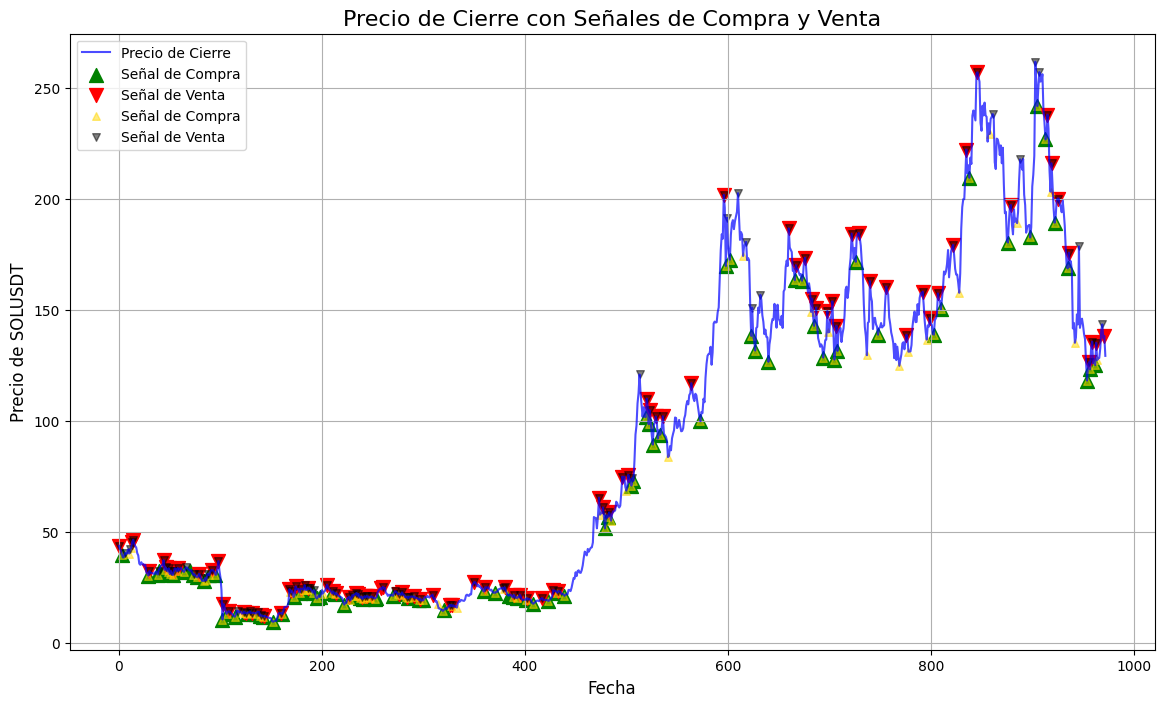

Compra a 39.76 en 03/08/2022
Venta a 45.455 en 13/08/2022 | ROI: 14.32%
Compra a 30.4 en 29/08/2022
Venta a 32.405 en 30/08/2022 | ROI: 6.60%
Compra a 30.865 en 07/09/2022
Venta a 37.415 en 13/09/2022 | ROI: 21.22%
Compra a 32.96 en 14/09/2022
Venta a 34.11 en 15/09/2022 | ROI: 3.49%
Compra a 32.235 en 17/09/2022
Venta a 33.67 en 18/09/2022 | ROI: 4.45%
Compra a 31.07 en 19/09/2022
Venta a 32.605 en 20/09/2022 | ROI: 4.94%
Compra a 30.625 en 22/09/2022
Venta a 32.39 en 23/09/2022 | ROI: 5.76%
Compra a 32.32 en 26/09/2022
Venta a 33.86 en 27/09/2022 | ROI: 4.76%
Compra a 32.67 en 28/09/2022
Venta a 31.185 en 18/10/2022 | ROI: -4.55%
Compra a 27.995 en 23/10/2022
Venta a 32.925 en 31/10/2022 | ROI: 17.61%
Compra a 30.79 en 03/11/2022
Venta a 36.895 en 06/11/2022 | ROI: 19.83%
Compra a 10.61 en 10/11/2022
Venta a 17.56 en 11/11/2022 | ROI: 65.50%
Compra a 13.135 en 14/11/2022
Venta a 14.31 en 16/11/2022 | ROI: 8.95%
Compra a 11.825 en 22/11/2022
Venta a 14.18 en 01/12/2022 | ROI: 19.92%
C

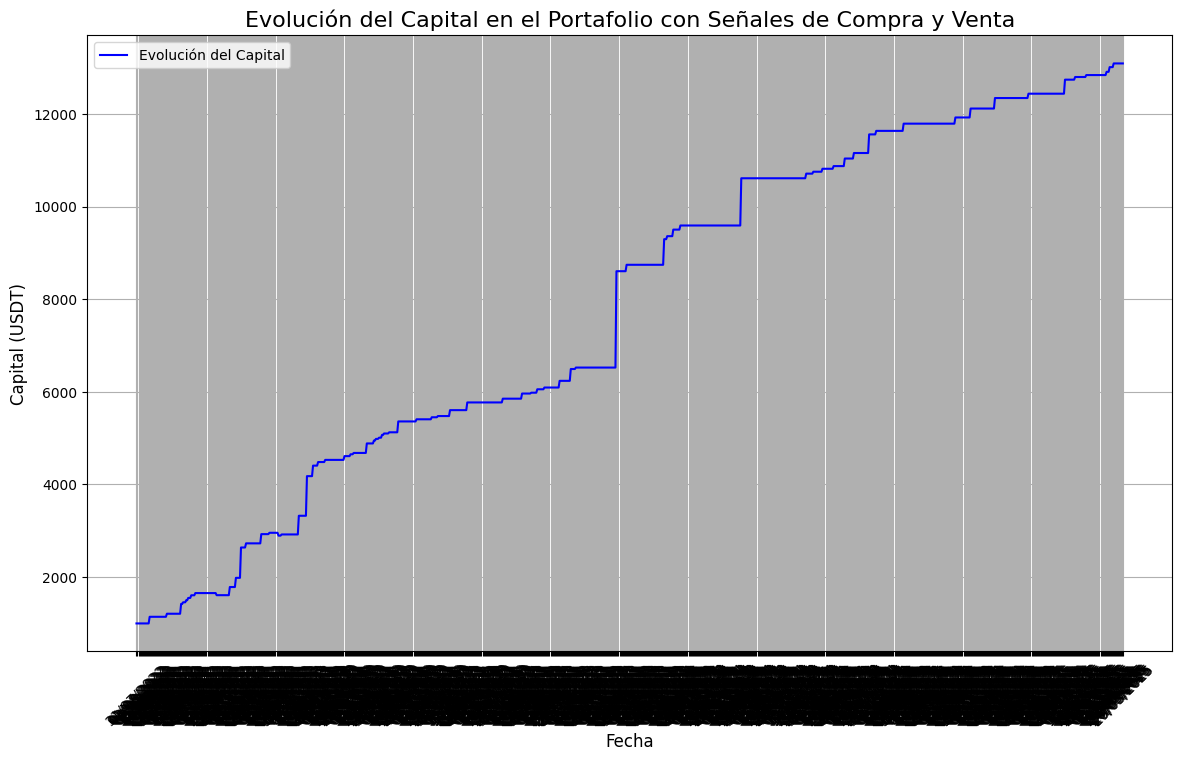

Capital Final: 1838.68 USDT
Tasa de Retorno Acumulado: 83.87%
Volatilidad Anualizada: 0.8915
Relación de Sharpe: -0.0082
Drawdown Máximo: -0.60%


C:\Users\POZOLE\Documents\pp\nohtyp\practice_algo_trading\modelos_dummys_ver2.0\superv_model_wo_bssignals_script.py:208: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  validaciones['date'] = pd.to_datetime(validaciones['date'])


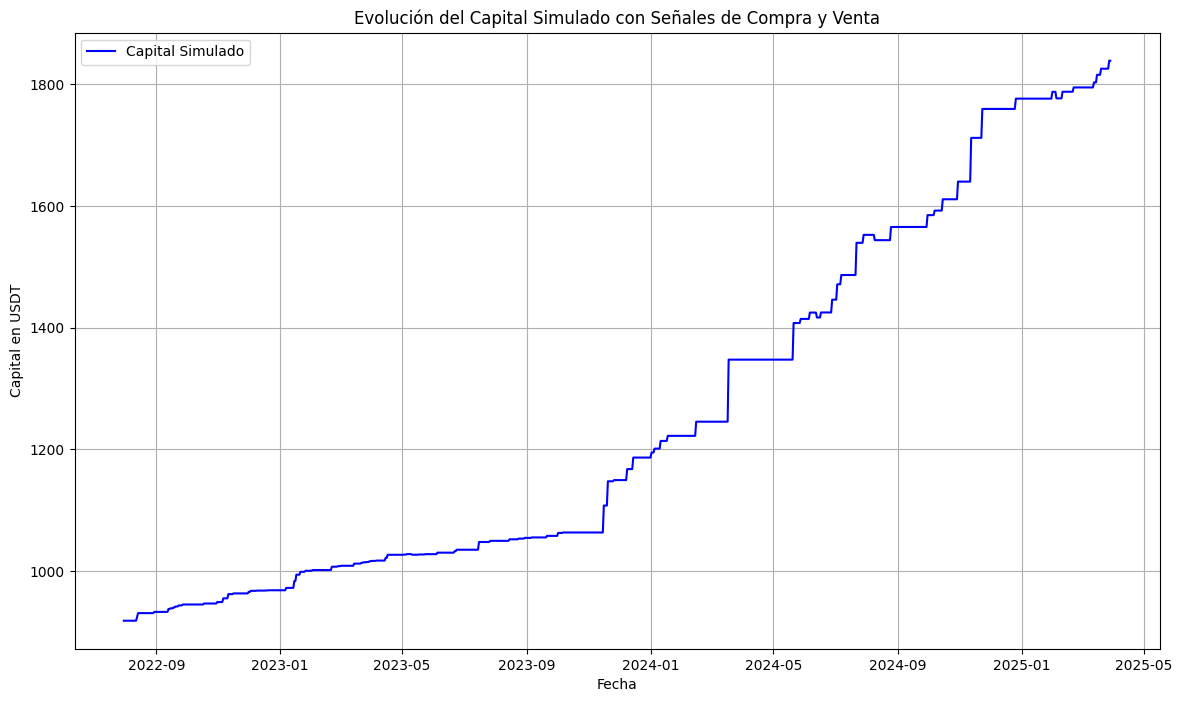

In [11]:
import os
os.chdir('C:/Users/POZOLE/Documents/pp/nohtyp/practice_algo_trading/modelos_dummys_ver2.0')
from superv_model_wo_bssignals_script import clf, scaler # type: ignore

# Supongamos que "df_df_ind" es un DataFrame con la misma estructura que "data" pero sin la columna 'signals'
df_df_ind =df_ind.copy()  # Asegúrate de trabajar sobre una copia

# Seleccionar las columnas de características
features = ['open', 'value', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
            'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']

X_nuevos =df_ind[features]

# Normalizar usando el mismo scaler que se ajustó en el entrenamiento
X_nuevos_scaled = scaler.transform(X_nuevos)

# Realizar predicciones en los nuevos datos
predicciones = clf.predict(X_nuevos_scaled)

# Añadir las predicciones al DataFrame de nuevos datos para su análisis
df_df_ind['predicted_signals'] = predicciones

In [12]:
import numpy as np

# Si 'predicted_signals' está en df_df_ind, haz lo siguiente:
df_df_ind['buy_signal'] = np.where(df_df_ind['predicted_signals'] == 'buy', 1, 0)
df_df_ind['sell_signal'] = np.where(df_df_ind['predicted_signals'] == 'sell', 1, 0)


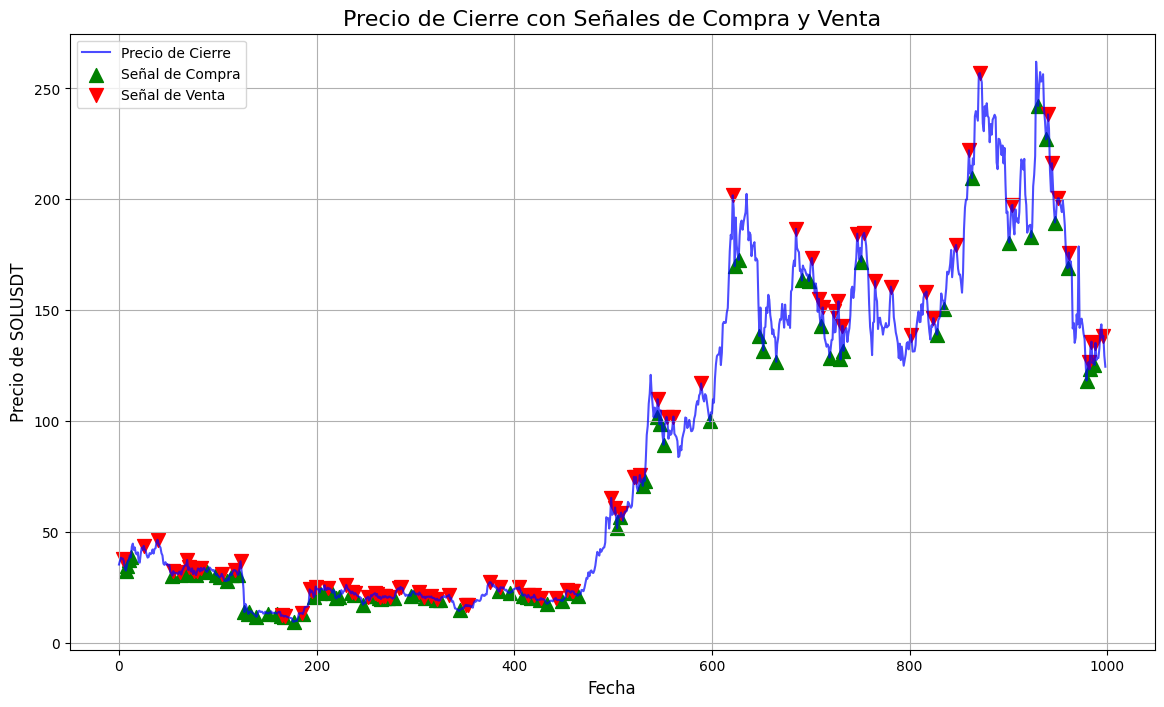

In [13]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df_df_ind.index[df_df_ind['buy_signal'] == 1], df_df_ind['open'][df_df_ind['buy_signal'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df_df_ind.index[df_df_ind['sell_signal'] == 1], df_df_ind['open'][df_df_ind['sell_signal'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title('Precio de Cierre con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {'SOLUSDT'}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

Compra a 32.69 en 2022-07-13 00:00:00
Venta a 43.83 en 2022-07-31 00:00:00 | ROI: 34.08%
Compra a 30.42 en 2022-08-29 00:00:00
Venta a 32.42 en 2022-08-30 00:00:00 | ROI: 6.57%
Compra a 30.89 en 2022-09-07 00:00:00
Venta a 37.45 en 2022-09-13 00:00:00 | ROI: 21.24%
Compra a 32.98 en 2022-09-14 00:00:00
Venta a 34.11 en 2022-09-15 00:00:00 | ROI: 3.43%
Compra a 32.25 en 2022-09-17 00:00:00
Venta a 33.69 en 2022-09-18 00:00:00 | ROI: 4.47%
Compra a 31.12 en 2022-09-19 00:00:00
Venta a 32.62 en 2022-09-20 00:00:00 | ROI: 4.82%
Compra a 30.66 en 2022-09-22 00:00:00
Venta a 32.4 en 2022-09-23 00:00:00 | ROI: 5.68%
Compra a 32.32 en 2022-09-26 00:00:00
Venta a 33.89 en 2022-09-27 00:00:00 | ROI: 4.86%
Compra a 32.68 en 2022-09-28 00:00:00
Venta a 31.22 en 2022-10-18 00:00:00 | ROI: -4.47%
Compra a 28.01 en 2022-10-23 00:00:00
Venta a 32.95 en 2022-10-31 00:00:00 | ROI: 17.64%
Compra a 30.81 en 2022-11-03 00:00:00
Venta a 36.89 en 2022-11-06 00:00:00 | ROI: 19.73%
Compra a 13.97 en 2022-11-10

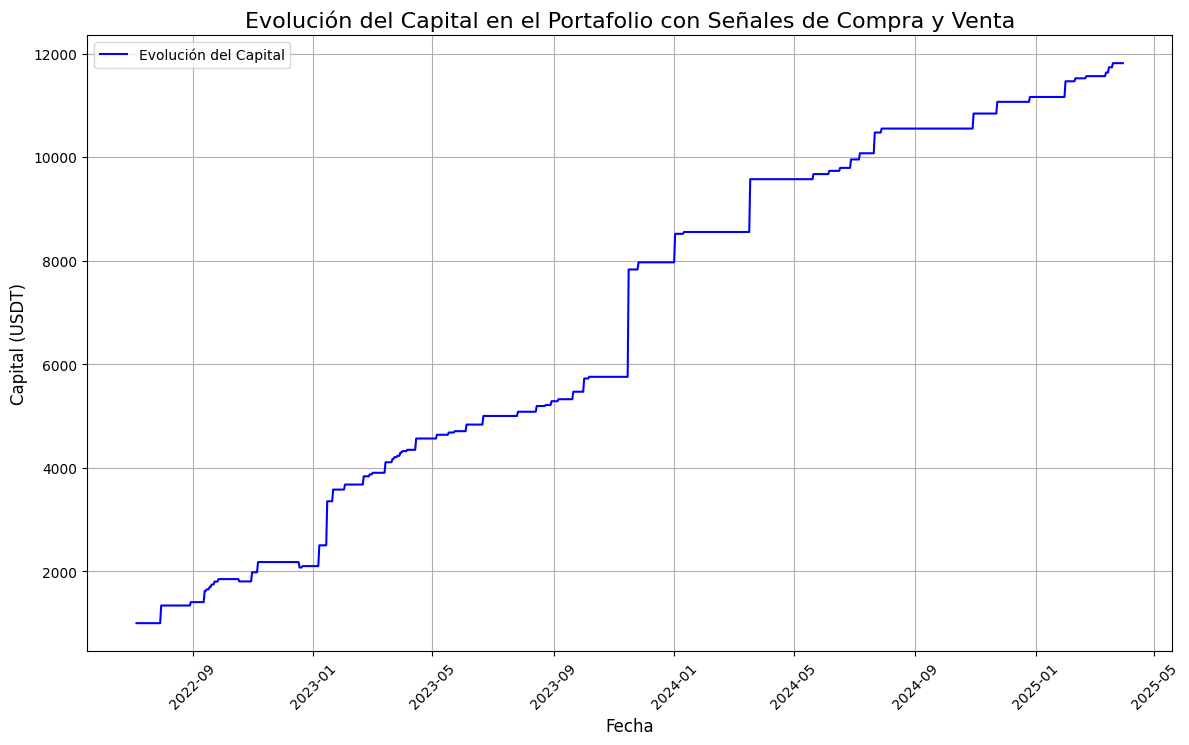

In [14]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open']
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open']
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})

# Graficar la evolución del capital a lo largo del tiempo
plt.figure(figsize=(14, 8))
plt.plot(df_capital['Date'], df_capital['Capital'], label='Evolución del Capital', color='blue')
plt.title('Evolución del Capital en el Portafolio con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital (USDT)', fontsize=12)
plt.grid(True)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()


Capital Final: 1685.26 USDT
Tasa de Retorno Acumulado: 68.53%
Volatilidad Anualizada: 0.8172
Relación de Sharpe: -0.0091
Drawdown Máximo: -8.73%


C:\Users\POZOLE\AppData\Local\Temp\ipykernel_18172\3637441749.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_df_ind['daily_return'] = df_df_ind['open'].pct_change()


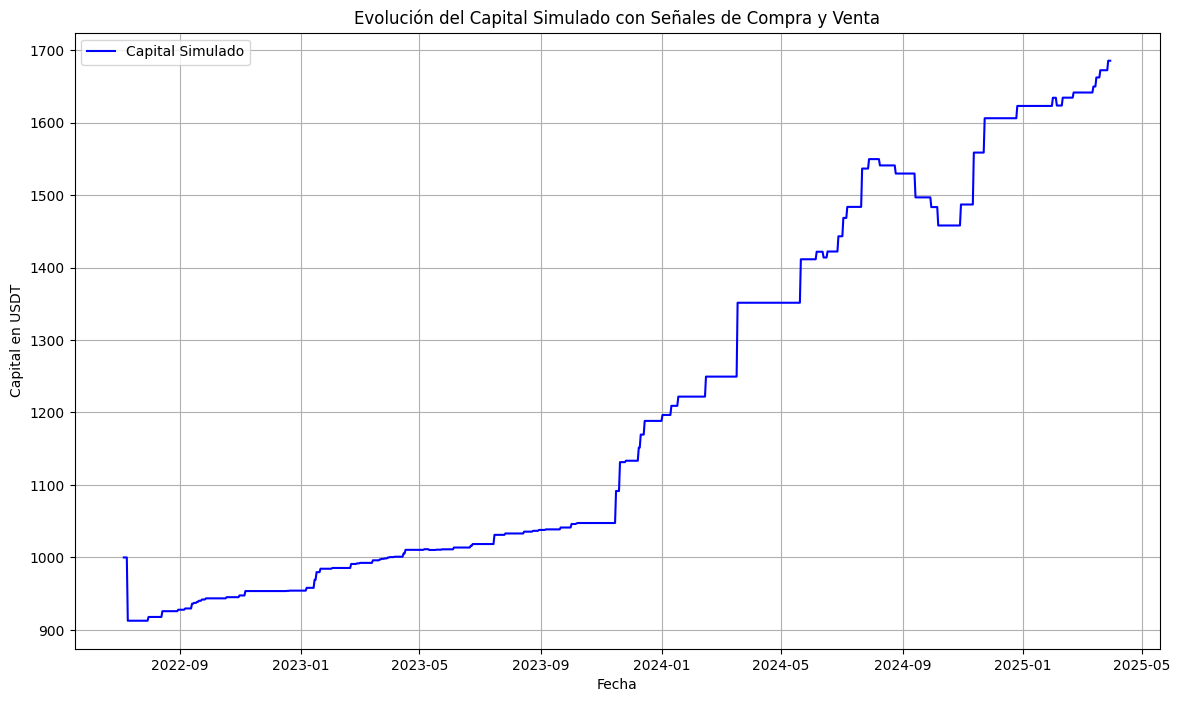

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supongamos que tienes los datos necesarios con las señales predichas
# Aquí se toma el dataframe 'df_df_ind' con las señales de compra y venta predichas

# Asegúrate de que las fechas estén en el formato correcto
df_df_ind['date'] = pd.to_datetime(df_df_ind['date'])
df_df_ind.sort_values('date', inplace=True)

# Calcula el retorno diario en base al precio 'open'
df_df_ind['daily_return'] = df_df_ind['open'].pct_change()

# Calcula el retorno acumulado de la inversión
initial_capital = 1000  # Capital inicial
df_df_ind['capital'] = initial_capital * (1 + df_df_ind['daily_return']).cumprod()

# Simular las compras y ventas
capital = initial_capital
capital_series = []

for i in range(len(df_df_ind)):
    if df_df_ind['buy_signal'].iloc[i]:
        buy_price = df_df_ind['open'].iloc[i]
    if df_df_ind['sell_signal'].iloc[i]:
        sell_price = df_df_ind['open'].iloc[i]
        capital += (sell_price - buy_price)  # Calcular el retorno de la venta
    capital_series.append(capital)

df_df_ind['capital_simulado'] = capital_series

# 1. Calcular el Drawdown
df_df_ind['capital_max'] = df_df_ind['capital_simulado'].cummax()
df_df_ind['drawdown'] = df_df_ind['capital_simulado'] - df_df_ind['capital_max']
df_df_ind['drawdown_pct'] = df_df_ind['drawdown'] / df_df_ind['capital_max'] * 100

# 2. Calcular la volatilidad (desviación estándar de los retornos diarios)
volatilidad = df_df_ind['daily_return'].std() * np.sqrt(252)  # Volatilidad anualizada

# 3. Calcular la rentabilidad diaria promedio
rentabilidad_diaria = df_df_ind['daily_return'].mean()

# 4. Calcular la relación de Sharpe
tasa_libre_riesgo = 0.01  # Asumimos una tasa libre de riesgo del 1%
sharpe_ratio = (rentabilidad_diaria - tasa_libre_riesgo) / volatilidad

# 5. Resultado Final
capital_final = df_df_ind['capital_simulado'].iloc[-1]
tasa_retorno_acumulado = (capital_final - initial_capital) / initial_capital * 100

# Imprimir métricas de desempeño
print(f"Capital Final: {capital_final:.2f} USDT")
print(f"Tasa de Retorno Acumulado: {tasa_retorno_acumulado:.2f}%")
print(f"Volatilidad Anualizada: {volatilidad:.4f}")
print(f"Relación de Sharpe: {sharpe_ratio:.4f}")
print(f"Drawdown Máximo: {df_df_ind['drawdown_pct'].min():.2f}%")

# Graficar la evolución del capital simulado
plt.figure(figsize=(14, 8))
plt.plot(df_df_ind['date'], df_df_ind['capital_simulado'], label='Capital Simulado', color='blue')
plt.title('Evolución del Capital Simulado con Señales de Compra y Venta')
plt.xlabel('Fecha')
plt.ylabel('Capital en USDT')
plt.grid(True)
plt.legend()
plt.show()


In [16]:
import pandas as pd

# Crear una copia del DataFrame
df = df_df_ind.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Tarifa de Bybit (comisiones de maker y taker)
maker_fee = 0.0001  # 0.01% en cada compra (maker)
taker_fee = 0.00075  # 0.075% en cada venta (taker)

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df.iterrows():
    # Señal de compra
    if row['buy_signal'] == 1 and not holding:
        buy_price = row['open'] * (1 + maker_fee)  # Ajustar por la comisión maker
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price:.2f} en {df['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal'] == 1 and holding:
        sell_price = row['open'] * (1 - taker_fee)  # Ajustar por la comisión taker
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price:.2f} en {df['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_capital = pd.DataFrame({
    'Date': df['date'],
    'Capital': capital_history
})


Compra a 32.69 en 2022-07-13 00:00:00
Venta a 43.80 en 2022-07-31 00:00:00 | ROI: 33.96%
Compra a 30.42 en 2022-08-29 00:00:00
Venta a 32.40 en 2022-08-30 00:00:00 | ROI: 6.48%
Compra a 30.89 en 2022-09-07 00:00:00
Venta a 37.42 en 2022-09-13 00:00:00 | ROI: 21.13%
Compra a 32.98 en 2022-09-14 00:00:00
Venta a 34.08 en 2022-09-15 00:00:00 | ROI: 3.34%
Compra a 32.25 en 2022-09-17 00:00:00
Venta a 33.66 en 2022-09-18 00:00:00 | ROI: 4.38%
Compra a 31.12 en 2022-09-19 00:00:00
Venta a 32.60 en 2022-09-20 00:00:00 | ROI: 4.73%
Compra a 30.66 en 2022-09-22 00:00:00
Venta a 32.38 en 2022-09-23 00:00:00 | ROI: 5.59%
Compra a 32.32 en 2022-09-26 00:00:00
Venta a 33.86 en 2022-09-27 00:00:00 | ROI: 4.77%
Compra a 32.68 en 2022-09-28 00:00:00
Venta a 31.20 en 2022-10-18 00:00:00 | ROI: -4.55%
Compra a 28.01 en 2022-10-23 00:00:00
Venta a 32.93 en 2022-10-31 00:00:00 | ROI: 17.54%
Compra a 30.81 en 2022-11-03 00:00:00
Venta a 36.86 en 2022-11-06 00:00:00 | ROI: 19.63%
Compra a 13.97 en 2022-11-1